# Goal of this Lecture Note

In these notes, we want to investigate the role of the *learning rate*, in particular its magnitude, in the gradient descent algorithm, starting with the simplest possible setting.

---

## Setup

Consider the general formulation of gradient descent.  
Let $\beta \in \mathbb{R}^d$ be the parameters we want to estimate, and let $\mathcal{L}(\beta)$ be the objective (e.g., loss function) we want to minimize.  
Gradient descent updates the parameters according to

$$
\hat{\beta}_{t+1} = \hat{\beta}_t - \lambda \nabla_{\beta} \mathcal{L}(\hat{\beta}_t),
$$

where $\lambda > 0$ is the **learning rate**.

---

## Why the Magnitude of the Learning Rate Matters

The learning rate controls the fundamental trade-off between **speed** and **stability**.

The gradient provides the *direction* of steepest descent, but the learning rate determines the *distance* traveled along that direction at each step.

- If **$\lambda$** is *small*, each update is cautious. Convergence is stable but slow.
- If **$\lambda$** is *large but still below the stability threshold*, updates are aggressive and convergence is fast.
- If **$\lambda$** is *too large*, the algorithm overshoots the minimum, oscillates, and can eventually diverge.

To study these behaviors precisely and transparently, we now turn to a simple model where everything can be computed explicitly: **linear regression with an intercept and slope**.

---

## A Simple Test Case: Linear Regression

We consider the parameter vector

$$
\beta =
\begin{pmatrix}
\beta^{(0)} \\
\beta^{(1)}
\end{pmatrix}
\in \mathbb{R}^2,
$$

and the (mean squared error) loss function

$$
\mathcal{L}(\beta)
=
\frac{1}{N}
\sum_{i=1}^N \big( y_i - \beta^{(0)} - \beta^{(1)} x_i \big)^2,
$$

where the dataset is

$$
\mathcal{D} = \{(x_i, y_i)\}_{i=1}^N.
$$

This setting is simple enough to allow us to derive the gradient, Hessian, and the exact dynamical system generated by gradient descent, making it ideal for studying the role of the learning rate.

## Calculating the gradient

Then the gradient of the loss is
$$
\begin{align}
\nabla_\beta \mathcal{L}(\beta) = 
-2\begin{pmatrix}
\bar{y}-\beta^{(0)} - \beta^{(1)}\bar{x}\\
\overline{yx}- \beta^{(0)} \bar{x} - \beta^{(1)} \overline{x^2}
\end{pmatrix}
\end{align},
$$
where 
$$
\bar{x} = \frac{1}{N}\sum_{i=1}^N x_i, \quad
\bar{y} = \frac{1}{N}\sum_{i=1}^N y_i, \quad
\overline{x^2} = \frac{1}{N}\sum_{i=1}^N x_i^2, \quad
\overline{xy} = \frac{1}{N}\sum_{i=1}^N x_i y_i.
$$

The dynamical system that describes the gradient descent is
$$
\begin{pmatrix}
\hat{\beta}^{(0)}_{t+1}\\[4pt]
\hat{\beta}^{(1)}_{t+1}
\end{pmatrix}
=
\begin{pmatrix}
\hat{\beta}^{(0)}_{t}\\[4pt]
\hat{\beta}^{(1)}_{t}
\end{pmatrix}
+ \lambda\times 2
\begin{pmatrix}
\bar{y}-\hat{\beta}^{(0)}_t - \hat{\beta}^{(1)}_t \bar{x}\\[6pt]
\overline{xy}- \hat{\beta}^{(0)}_t \bar{x} - \hat{\beta}^{(1)}_t \overline{x^2}
\end{pmatrix},
$$

which simplifies to
$$
\hat{\beta}_{t+1} = (I-2\lambda P)\hat{\beta}_t + 2\lambda c
$$

where 

$$
P \equiv \begin{bmatrix}
1 & \bar{x}\\
\bar{x} & \overline{x^2}
\end{bmatrix}, 
~\text{and}~
c \equiv \begin{pmatrix}
\bar{y}\\
\overline{xy}
\end{pmatrix}
$$

## Fixed point
This system has a unique fixed point that solves
$$
P \beta^* = c ~ \text{or}~ \begin{bmatrix}
1 & \bar{x}\\
\bar{x} & \overline{x^2}
\end{bmatrix} \begin{pmatrix}
\beta^{(0)^*}\\
\beta^{(1)^*} 
\end{pmatrix} = \begin{pmatrix}
\bar{y}\\
\overline{xy}
\end{pmatrix}
$$
Therefore
$$
\begin{align}
\beta^* = P^{-1}c
\end{align}
$$
This is exactly the 2-D version of $(X'X)^{-1}X'Y$ that we learn in stats/econometrics.

## The stability of the dynamical system 
Define 
$$
\hat{e}_t \equiv \hat{\beta}_t-\beta^*,
$$
which represents the deviation from the fixed point. The dynamics of this deviation are
$$
\begin{align}
\hat{e}_{t+1} = (I-2\lambda P) \hat{e}_t.
\end{align}
$$

Let $\mu_1$ and $\mu_2$ be the eigenvalues of $P$, and let $\nu_1$ and $\nu_2$ be the corresponding eigenvectors.

The solution can be written as 

$$
\begin{align}
\hat{e}_t = \alpha_1 \nu_1 (1-2\lambda \mu_1)^t + \alpha_2 \nu_2 (1-2\lambda \mu_2)^t 
\end{align}
$$
where $\alpha_1$ and $\alpha_2$ are determined by the initial condition $e_0 = \hat{\beta}_0-\beta^*$. 

### Convergence
For gradient descent to converge, we need
$$
\lim_{t\rightarrow \infty} \hat{e}_t = 0 \quad \text{for all} \quad \hat{e}_0
$$

That means 
1. $|1-2\lambda \mu_1|<1$ $\quad$ $\rightarrow$ $\quad$ $0<\lambda<\frac{1}{\mu_1}$
2. $|1-2\lambda \mu_2|<1$ $\quad$ $\rightarrow$ $\quad$ $0<\lambda<\frac{1}{\mu_2}$

Therefore

$$
\begin{align}
\boxed{0 < \lambda < \frac{1}{\mu_{\text{max}}}}
\end{align}
$$

we define 

$$
\mu^* \equiv \frac{1}{\mu_{\text{max}}}.
$$

-----
Let’s test this in practice. Here I use `PyTorch`, but the gradient can also be defined manually to reproduce the same update rule.

In [1]:
## Importing packages
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import gridspec


In [2]:
## Generating data
torch.manual_seed(1)
N = 200
true_b0 = 1.5
true_b1 = -2

x = 0.25*torch.randn(N, 1)                   # shape (N, 1)
eps = 0.1 * torch.randn(N, 1)
y = true_b0 + true_b1 * x + eps 

In [3]:
## Forming P matrix
x_bar = x.mean()
x_sq_bar = (x**2).mean()

xy_bar = (x*y).mean()
y_bar = y.mean()

c = torch.tensor([[y_bar],[xy_bar]])

P = torch.tensor([[1.0,x_bar],[x_bar,x_sq_bar]])

β = torch.inverse(P)@c

eigenvalues = torch.linalg.eigvalsh(P)

μ_max = eigenvalues.max().item()

In [4]:
## Divergent case

In [5]:
## define the linear function (neural net)
model = nn.Linear(in_features=1, out_features=1)

with torch.no_grad():
    model.weight.fill_(0.0)   # sets w = 0
    model.bias.fill_(0.0)     # sets b = 0


## setting the optimizer
learning_rate = (1/μ_max)*(1.01)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

b0_list_diverge = []
b1_list_diverge = []

num_steps = 100

for t in range(num_steps):
    b0_hat = model.bias.item()
    b1_hat = model.weight.item()

    # Save them
    b0_list_diverge.append(b0_hat)
    b1_list_diverge.append(b1_hat)

    # Forward pass
    y_pred = model(x)

    # Compute loss
    loss = criterion(y_pred, y)

    # Zero gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Gradient descent update
    optimizer.step()

    # Extract parameters
   

    # Optional printout
    #print(f"step {t:4d} | loss = {loss:.5f} | b0 = {b0_hat:.3f}, b1 = {b1_hat:.3f}")

b0_array_div = np.array(b0_list_diverge)
b1_array_div = np.array(b1_list_diverge)

In [6]:
## Convergant case

In [7]:
## define the linear function (neural net)
model = nn.Linear(in_features=1, out_features=1)

with torch.no_grad():
    model.weight.fill_(0.0)   # sets w = 0
    model.bias.fill_(0.0)     # sets b = 0


## setting the optimizer
learning_rate = (1/μ_max)*(0.9)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

b0_list_convergent = []
b1_list_convergent = []

num_steps = 100

for t in range(num_steps):
    b0_hat = model.bias.item()
    b1_hat = model.weight.item()

    # Save them
    b0_list_convergent.append(b0_hat)
    b1_list_convergent.append(b1_hat)

    # Forward pass
    y_pred = model(x)

    # Compute loss
    loss = criterion(y_pred, y)

    # Zero gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Gradient descent update
    optimizer.step()

    # Extract parameters
   

    # Optional printout
    #print(f"step {t:4d} | loss = {loss:.5f} | b0 = {b0_hat:.3f}, b1 = {b1_hat:.3f}")
b0_array_conv= np.array(b0_list_convergent)
b1_array_conv = np.array(b1_list_convergent)

In [8]:
## Plotting the results

In [9]:
import matplotlib.pyplot as plt
from matplotlib import cm

fontsize= 14
ticksize = 14
figsize = (10, 6)
params_fig = {'font.family':'serif',
    "figure.figsize":figsize,
    'figure.dpi': 80,
    'figure.edgecolor': 'k',
    'font.size': fontsize,
    'axes.labelsize': fontsize,
    'axes.titlesize': fontsize,
    'xtick.labelsize': ticksize,
    'ytick.labelsize': ticksize
}
plt.rcParams.update(params_fig)

In [10]:
np.min([1,2])

1

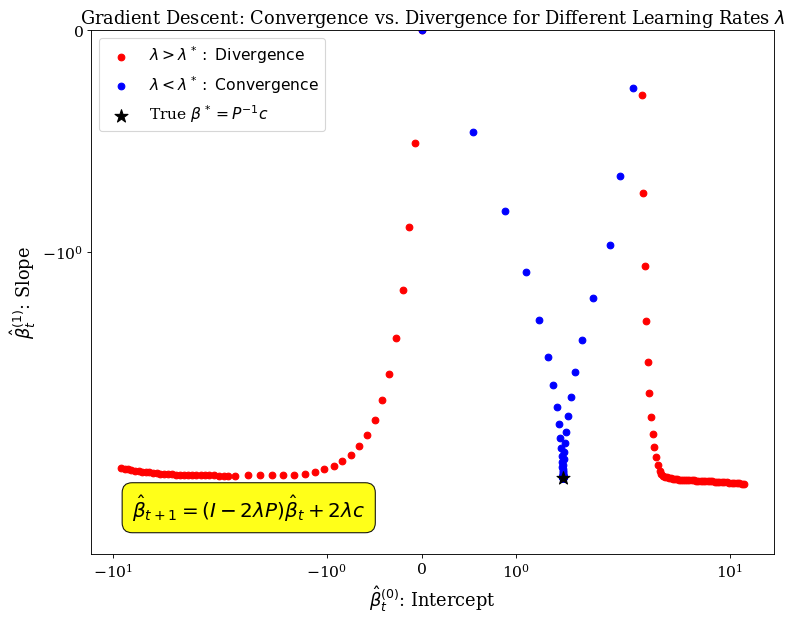

In [11]:
x_low_lim  = np.min([1.5 * b0_array_div.min(),0.9* b0_array_div.min()])
x_high_lim = 1.5 * b0_array_div.max()

y_low_lim  = np.min([1.5 * b1_array_div.min(), 1.5 * b1_array_div.min()])
y_high_lim = 1.5 * b1_array_div.max()

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# --- Scatter plots for convergence and divergence ---
ax.scatter(b0_array_div,  b1_array_div,  color="r", label=r"$\lambda>\lambda^*:~\mathrm{Divergence}$")
ax.scatter(b0_array_conv, b1_array_conv, color="b", label=r"$\lambda<\lambda^*:~\mathrm{Convergence}$")
ax.scatter(β[0], β[1], color='k', marker='*', s=150, label=r'True $\beta^* = P^{-1}c$')
equation = (
    r"$\hat{\beta}_{t+1} = (I-2\lambda P)\hat{\beta}_t + 2\lambda c$"
)


ax.text(
    0.06, 0.06,
    equation,
    transform=ax.transAxes,
    fontsize=18,
    verticalalignment='bottom',
    horizontalalignment='left',
    bbox=dict(
        boxstyle='round,pad=0.5',
        facecolor='yellow',
        edgecolor='black',
        alpha=0.9
    )
)



# --- Labels and Title ---
ax.set_xlabel(r'$\hat{\beta}^{(0)}_t$: Intercept', fontsize=16)
ax.set_ylabel(r'$\hat{\beta}^{(1)}_t$: Slope', fontsize=16)
ax.set_title(r"Gradient Descent: Convergence vs. Divergence for Different Learning Rates $\lambda$", fontsize=16)

# --- Axis limits ---
ax.set_xlim(x_low_lim, x_high_lim)
ax.set_ylim(y_low_lim, y_high_lim)

# --- Symmetric log scale ---
ax.set_xscale("symlog")
ax.set_yscale("symlog")

ax.legend()

plt.tight_layout()
plt.show()


In [12]:
## Plotting the 3D

In [13]:
def loss_numpy_path(beta_0,beta_1,x,y):
    x_np = x.numpy()   # shape (N,)
    y_np = y.numpy()   # shape (N,)
    error = y_np- beta_0 - beta_1*x_np
    mse = (error**2).mean(axis = 0)
    return mse

In [14]:
def make_surface_and_curve(ax, b0_array, b1_array, x, y, title, color):
    # Flatten arrays to 1D
    b0_array = np.asarray(b0_array).reshape(-1)
    b1_array = np.asarray(b1_array).reshape(-1)

    # Surface ranges
    b0_min, b0_max = 1.1*np.min(b0_array), 1.1*np.max(b0_array)
    b1_min, b1_max = 1.1*np.min(b1_array), 1.1*np.max(b1_array)

    pad0 = 0.1 * (b0_max - b0_min)
    pad1 = 0.1 * (b1_max - b1_min)

    b0_grid = np.linspace(b0_min - pad0, b0_max + pad0, 50)
    b1_grid = np.linspace(b1_min - pad1, b1_max + pad1, 50)

    B0, B1 = np.meshgrid(b0_grid, b1_grid)

    # Compute loss surface using .item() to avoid DeprecationWarning
    Z = np.zeros_like(B0)
    for i in range(B0.shape[0]):
        for j in range(B0.shape[1]):
            Z[i, j] = loss_numpy_path(B0[i, j].item(), B1[i, j].item(), x, y)

    # Compute loss along path
    loss_vals = np.array([
        loss_numpy_path(b0.item() if hasattr(b0,'item') else b0,
                        b1.item() if hasattr(b1,'item') else b1,
                        x, y)
        for b0, b1 in zip(b0_array, b1_array)
    ]).reshape(-1)

    # Plot 3D surface + path
    ax.plot_surface(B0, B1, Z, cmap='viridis', alpha=0.7)
    ax.plot(b0_array, b1_array, loss_vals, color=color, linewidth=3)

    ax.set_title(title, fontsize=18)
    ax.set_xlabel(r'$\hat{\beta}^{(0)}_t$: Intercept', fontsize=16)
    ax.set_ylabel(r'$\hat{\beta}^{(1)}_t$: Slope', fontsize=16)
    ax.set_zlabel("")
    
    ax.set_xticklabels([]) 
    ax.set_yticklabels([])

    # Remove grid lines
    ax.xaxis._axinfo["grid"]["linewidth"] = 0
    ax.yaxis._axinfo["grid"]["linewidth"] = 0
    ax.zaxis._axinfo["grid"]["linewidth"] = 0








C:\Users\mahdi\AppData\Local\Temp\ipykernel_7148\615503409.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z[i, j] = loss_numpy_path(B0[i, j].item(), B1[i, j].item(), x, y)
C:\Users\mahdi\AppData\Local\Temp\ipykernel_7148\615503409.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z[i, j] = loss_numpy_path(B0[i, j].item(), B1[i, j].item(), x, y)


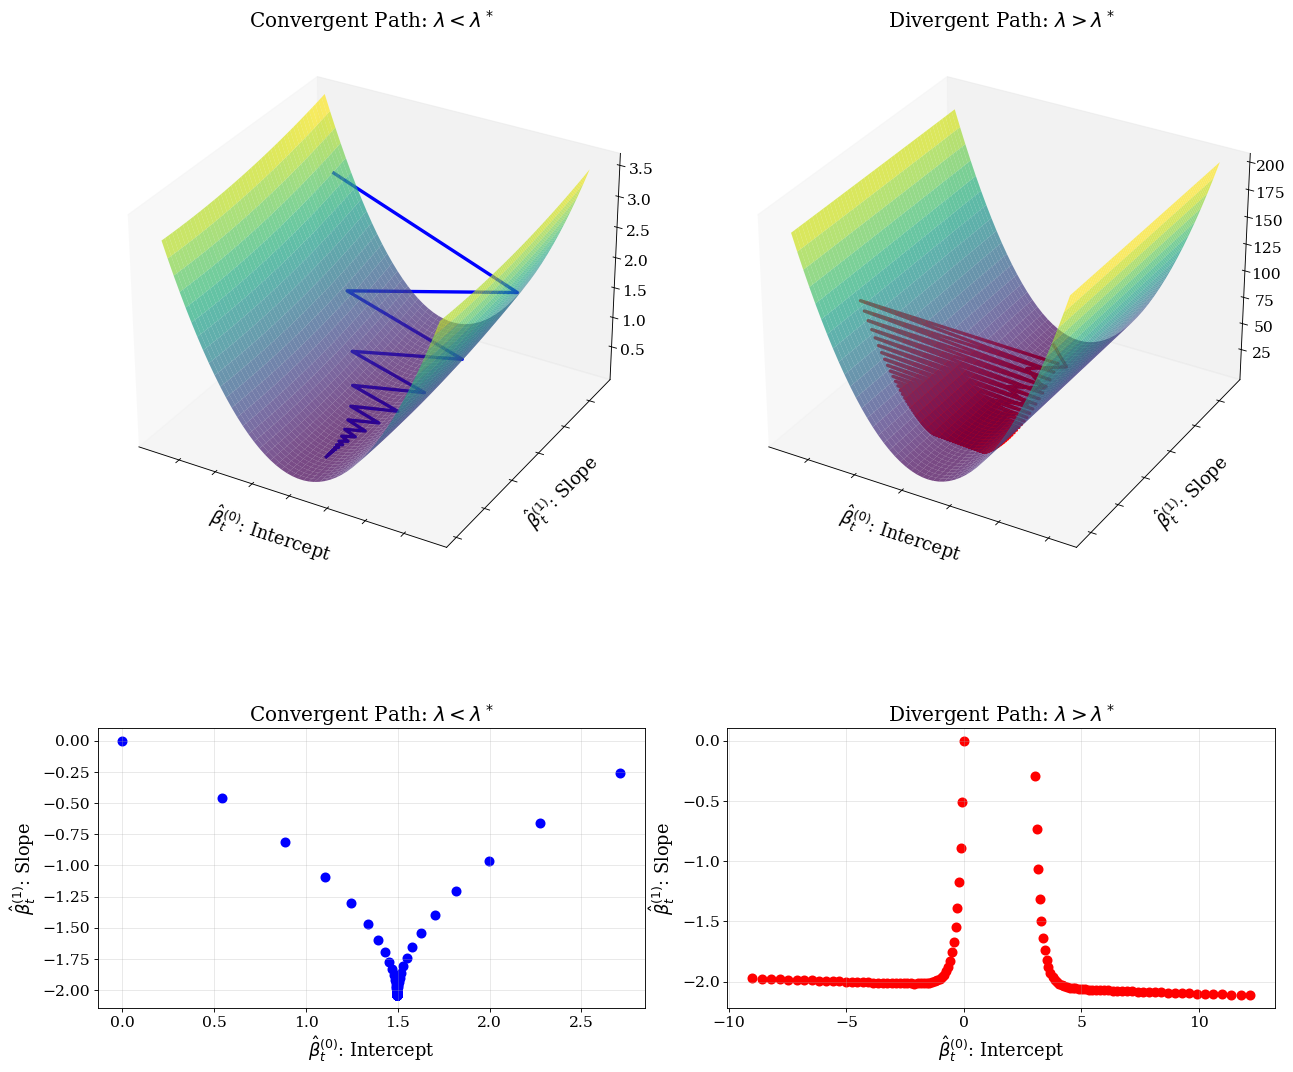

In [15]:

fig = plt.figure(figsize=(16, 14))
gs = gridspec.GridSpec(2, 2, height_ratios=[2.2, 1])   # enlarge top row

# Top-left
ax1 = fig.add_subplot(gs[0, 0], projection='3d')
make_surface_and_curve(
    ax1, b0_array_conv, b1_array_conv, x, y,
    r"Convergent Path: $\lambda< \lambda^*$", color="b"
)

# Top-right
ax2 = fig.add_subplot(gs[0, 1], projection='3d')
make_surface_and_curve(
    ax2, b0_array_div, b1_array_div, x, y,
    r"Divergent Path: $\lambda> \lambda^*$", color="r"
)

# Bottom-left
ax3 = fig.add_subplot(gs[1, 0])
ax3.scatter(b0_array_conv, b1_array_conv, color="b", linewidth=3)
ax3.set_title(r"Convergent Path: $\lambda< \lambda^*$", fontsize = 18)
ax3.grid(True, alpha=0.3)
ax3.set_xlabel(r'$\hat{\beta}^{(0)}_t$: Intercept', fontsize=16)
ax3.set_ylabel(r'$\hat{\beta}^{(1)}_t$: Slope', fontsize=16)

# Bottom-right
ax4 = fig.add_subplot(gs[1, 1])
ax4.scatter(b0_array_div, b1_array_div, color="r", linewidth=3)
ax4.set_title(r"Divergent Path: $\lambda> \lambda^*$", fontsize = 18)
ax4.grid(True, alpha=0.3)
ax4.set_xlabel(r'$\hat{\beta}^{(0)}_t$: Intercept', fontsize=16)
ax4.set_ylabel(r'$\hat{\beta}^{(1)}_t$: Slope', fontsize=16)
plt.subplots_adjust(
    wspace=0.15,
    hspace=0.25,
    left=0.05, right=0.97,
    top=0.95, bottom=0.05
)

plt.show()
